### Student Information
Name: Robert Justin

Student ID: 108006233

GitHub ID: rjustin25

Kaggle name: robert justin

Kaggle private scoreboard snapshot: 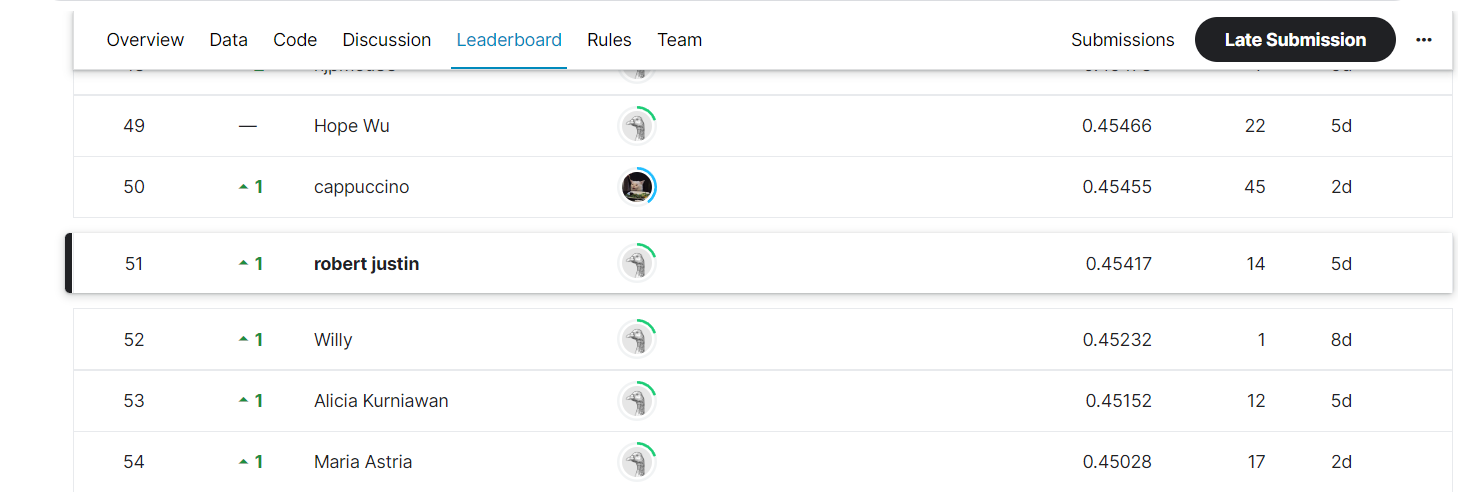

# 1. Data preparation
### 1.1 Load data from .csv and .json files

In [3]:
### Begin Assignment Here

import pandas as pd
import json

# import data as dataframes to merge
id_df = pd.read_csv('../input/kaggle-competition/data_identification.csv/data_identification.csv')
emotion_df = pd.read_csv('../input/kaggle-competition/emotion.csv/emotion.csv')
tweets_df = pd.read_json('../input/kaggle-competition/tweets_DM.json/tweets_DM.json', lines=True) 

In [4]:
# Check data size

print(id_df.shape)
print(emotion_df.shape)
print(tweets_df.shape)

(1867535, 2)
(1455563, 2)
(1867535, 5)


### 1.2 Preprocessing data

We set up both training and test datas with the available data we have from the .csv files and .json file. We have decided to exclude the hashtags and score data columns as the hashtags are anyway also included in the 'text' data and majority of the data don't include a hashtag. While I failed to find a proper way to interpret 'score' so it is left out for now.

In [5]:
tweets_df = pd.json_normalize(tweets_df._source)
tweets_df = tweets_df.drop(columns='tweet.hashtags')

In [6]:
train_df = id_df.merge(emotion_df, on='tweet_id').merge(tweets_df, left_on='tweet_id', right_on='tweet.tweet_id')

In [7]:
train_df = train_df.drop(columns=['tweet.tweet_id','identification'])
train_df = train_df.rename(columns={'tweet.text':'text'})

In [8]:
# check train data
train_df

,tweet_id,emotion,text
0,0x29e452,joy,Huge Respect🖒 @JohnnyVegasReal talking about l...
1,0x2b3819,joy,Yoooo we hit all our monthly goals with the ne...
2,0x2a2acc,trust,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...
3,0x2a8830,joy,Come join @ambushman27 on #PUBG while he striv...
4,0x20b21d,anticipation,@fanshixieen2014 Blessings!My #strength little...
...,...,...,...
1455558,0x227e25,disgust,@BBCBreaking Such an inspirational talented pe...
1455559,0x293813,sadness,And still #libtards won't get off the guy's ba...
1455560,0x1e1a7e,joy,When you sow #seeds of service or hospitality ...
1455561,0x2156a5,trust,@lorettalrose Will you be displaying some <LH>...


In [9]:
test_df = id_df[id_df['identification'] == 'test']
test_df = test_df.merge(tweets_df, left_on='tweet_id', right_on='tweet.tweet_id')

In [10]:
test_df = test_df.drop(columns=['tweet.tweet_id','identification'])
test_df = test_df.rename(columns={'tweet.text':'text'})

In [11]:
# check test data
test_df

,tweet_id,text
0,0x28cc61,@Habbo I've seen two separate colours of the e...
1,0x2db41f,@FoxNews @KellyannePolls No serious self respe...
2,0x2466f6,"Looking for a new car, and it says 1 lady owne..."
3,0x23f9e9,@cineworld “only the brave” just out and fount...
4,0x1fb4e1,Felt like total dog 💩 going into open gym and ...
...,...,...
411967,0x2c4dc2,6 year old walks in astounded. Mum! Look how b...
411968,0x31be7c,Only one week to go until the #inspiringvolunt...
411969,0x1ca58e,"I just got caught up with the manga for ""My He..."
411970,0x35c8ba,Speak only when spoken to and make hot ass mus...


I have decided to not shuffle data as it affected the training accuracy and evaluation accuracy heavily, it trains the model better with the unshuffled data, data from our dataset is also not sorted by any means so in this case we can account it already shuffled anyway.

In [12]:
# shuffle dataset
#train_df = train_df.sample(frac=1)
#test_df = test_df.sample(frac=1)

In [13]:
print("Shape of Training Data: ", train_df.shape)
print("Shape of Testing Data: ", test_df.shape)

Shape of Training Data:  (1455563, 3)
Shape of Testing Data:  (411972, 2)


### 1.3 Save as pickle data

In [14]:
## save to pickle file
train_df.to_pickle("/kaggle/working/train_df.pkl") 
test_df.to_pickle("/kaggle/working/test_df.pkl")

In [15]:
## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

In [16]:
# Breakdown training data size of each emotion value

train_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

# 2. Feature Engineering

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

We use *CountVectorizer* to obtain word frequency using the bag of words method with the nltk word tokenizer with a select few filters. *TfidVectorizer* yielded worse results compared to *CountVectorizer* even after testing using no filters or with the current used filters. As the dataset is quite huge, features obtained by the vectorizer are also very broad, I find cutting these features by setting max_features and using the default stop_words filter increased accuracy by a few percentages.

In [18]:
# build analyzers (bag-of-words)
vectorizer = CountVectorizer(tokenizer=nltk.word_tokenize, max_features=250000, stop_words='english')

vectorizer.fit(train_df['text'])
X_train = vectorizer.transform(train_df['text'])
y_train = train_df['emotion']
X_test = vectorizer.transform(test_df['text'])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


(1455563, 250000)
(1455563,)
(411972, 250000)


# 3. Model training

Model used is the sci-kit learn multinomial NaiveBayes model which is used to fit and train our pre-processed and tokenized data. Accuracy using deep-learning models are surely higher as they process and train data better however the multinomial NaiveBayes model did its job.

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

## build NB model
clf = MultinomialNB()

## train and predict
clf = clf.fit(X_train, y_train)
y_train_pred_nb = clf.predict(X_train)
y_test_pred_nb = clf.predict(X_test)

acc_train_nb = accuracy_score(y_true=y_train, y_pred=y_train_pred_nb)

print(f'train accuracy: {round(acc_train_nb, 3)}')

train accuracy: 0.592


# 4. Submission

In [20]:
pd.DataFrame(y_test_pred_nb)

,0
0,trust
1,sadness
2,joy
3,joy
4,joy
...,...
411967,disgust
411968,joy
411969,anticipation
411970,joy


In [21]:
# Merge emotion values with tweet_id
submission = test_df.merge(pd.DataFrame(y_test_pred_nb),left_index=True,right_index=True)

In [22]:
# Edit data frame to suit submission requirements
submission = submission.sort_index()
submission = submission.drop(columns='text')
submission = submission.rename(columns={'tweet_id':'id', 0:'emotion'})

In [23]:
submission

,id,emotion
0,0x28cc61,trust
1,0x2db41f,sadness
2,0x2466f6,joy
3,0x23f9e9,joy
4,0x1fb4e1,joy
...,...,...
411967,0x2c4dc2,disgust
411968,0x31be7c,joy
411969,0x1ca58e,anticipation
411970,0x35c8ba,joy


In [24]:
# Save submission df to csv file

submission.to_csv("/kaggle/working/submission.csv", index=False)